![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/1.Clinical_Named_Entity_Recognition_Model.ipynb)

# 1. Clinical Named Entity Recognition (NER)

## Blogposts and videos:

https://towardsdatascience.com/named-entity-recognition-ner-with-bert-in-spark-nlp-874df20d1d77

https://www.youtube.com/watch?v=YM-e4eOiQ34

https://medium.com/spark-nlp/named-entity-recognition-for-healthcare-with-sparknlp-nerdl-and-nercrf-a7751b6ad571

https://medium.com/atlas-research/ner-for-clinical-text-7c73caddd180

In [2]:
import os

jsl_secret = os.getenv('SECRET')

import sparknlp
sparknlp_version = sparknlp.version()
import sparknlp_jsl
jsl_version = sparknlp_jsl.version()

print (jsl_secret)

In [ ]:
# if you want to start the session with custom params as in start function above
def start(secret):
    builder = SparkSession.builder \
        .appName("Spark NLP Licensed") \
        .master("local[*]") \
        .config("spark.driver.memory", "16G") \
        .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
        .config("spark.kryoserializer.buffer.max", "2000M") \
        .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:"+sparknlp_version) \
        .config("spark.jars", "https://pypi.johnsnowlabs.com/"+jsl_secret+"/spark-nlp-jsl-"+jsl_version+".jar")
      
    return builder.getOrCreate()

#spark = start(secret)

In [3]:
import json
import os
from pyspark.ml import Pipeline,PipelineModel
from pyspark.sql import SparkSession

from sparknlp.annotator import *
from sparknlp_jsl.annotator import *
from sparknlp.base import *
import sparknlp_jsl
import sparknlp

params = {"spark.driver.memory":"16G",
"spark.kryoserializer.buffer.max":"2000M",
"spark.driver.maxResultSize":"2000M"}

spark = sparknlp_jsl.start(jsl_secret,params=params)

print ("Spark NLP Version :", sparknlp.version())
print ("Spark NLP_JSL Version :", sparknlp_jsl.version())

Spark NLP Version : 3.1.2
Spark NLP_JSL Version : 3.1.2


# Clinical NER Pipeline (with pretrained models)

In [ ]:
# Annotator that transforms a text column from dataframe into an Annotation ready for NLP
documentAssembler = DocumentAssembler()\
        .setInputCol("text")\
        .setOutputCol("document")

# Sentence Detector annotator, processes various sentences per line

#sentenceDetector = SentenceDetector()\
        #.setInputCols(["document"])\
        #.setOutputCol("sentence")
sentenceDetector = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare","en","clinical/models")\
        .setInputCols(["document"])\
        .setOutputCol("sentence")
 
# Tokenizer splits words in a relevant format for NLP
tokenizer = Tokenizer()\
        .setInputCols(["sentence"])\
        .setOutputCol("token")

# Clinical word embeddings trained on PubMED dataset
word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical","en","clinical/models")\
        .setInputCols(["sentence","token"])\
        .setOutputCol("embeddings")

# NER model trained on i2b2 (sampled from MIMIC) dataset
clinical_ner = MedicalNerModel.pretrained("ner_clinical_large","en","clinical/models")\
        .setInputCols(["sentence","token","embeddings"])\
        .setOutputCol("ner")

ner_converter = NerConverter()\
        .setInputCols(["sentence","token","ner"])\
        .setOutputCol("ner_chunk")

nlpPipeline = Pipeline(stages=[
        documentAssembler,
        sentenceDetector,
        tokenizer,
        word_embeddings,
        clinical_ner,
        ner_converter])


empty_data = spark.createDataFrame([[""]]).toDF("text")

model = nlpPipeline.fit(empty_data)


sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 363.9 KB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_clinical_large download started this may take some time.
Approximate size to download 13.9 MB
[OK!]


In [ ]:
model.stages

[DocumentAssembler_195a25bf805b,
 SentenceDetectorDLModel_d2546f0acfe2,
 REGEX_TOKENIZER_6cecd897e7c0,
 WORD_EMBEDDINGS_MODEL_9004b1d00302,
 MedicalNerModel_1a8637089929,
 NerConverter_9b33377c5232]

In [ ]:
clinical_ner.getClasses()

['O',
 'B-TREATMENT',
 'I-TREATMENT',
 'B-PROBLEM',
 'I-PROBLEM',
 'B-TEST',
 'I-TEST']

In [ ]:
clinical_ner.extractParamMap()

{Param(parent='MedicalNerModel_1a8637089929', name='batchSize', doc='Size of every batch'): 64,
 Param(parent='MedicalNerModel_1a8637089929', name='classes', doc='get the tags used to trained this MedicalNerModel'): ['O',
  'B-TREATMENT',
  'I-TREATMENT',
  'B-PROBLEM',
  'I-PROBLEM',
  'B-TEST',
  'I-TEST'],
 Param(parent='MedicalNerModel_1a8637089929', name='includeAllConfidenceScores', doc='whether to include all confidence scores in annotation metadata or just the score of the predicted tag'): False,
 Param(parent='MedicalNerModel_1a8637089929', name='includeConfidence', doc='whether to include confidence scores in annotation metadata'): True,
 Param(parent='MedicalNerModel_1a8637089929', name='inferenceBatchSize', doc='number of sentences to process in a single batch during inference'): 1,
 Param(parent='MedicalNerModel_1a8637089929', name='inputCols', doc='previous annotations columns, if renamed'): ['sentence',
  'token',
  'embeddings'],
 Param(parent='MedicalNerModel_1a8637089

In [ ]:
clinical_ner.getStorageRef()

'clinical'

In [ ]:
! wget -q https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/pubmed/pubmed_sample_text_small.csv

In [ ]:
import pyspark.sql.functions as F

pubMedDF = spark.read\
                .option("header", "true")\
                .csv("pubmed_sample_text_small.csv")\
                
pubMedDF.show(truncate=70)

+----------------------------------------------------------------------+
|                                                                  text|
+----------------------------------------------------------------------+
|The human KCNJ9 (Kir 3.3, GIRK3) is a member of the G-protein-activ...|
|BACKGROUND: At present, it is one of the most important issues for ...|
|OBJECTIVE: To investigate the relationship between preoperative atr...|
|Combined EEG/fMRI recording has been used to localize the generator...|
|Kohlschutter syndrome is a rare neurodegenerative disorder presenti...|
|Statistical analysis of neuroimages is commonly approached with int...|
|The synthetic DOX-LNA conjugate was characterized by proton nuclear...|
|Our objective was to compare three different methods of blood press...|
|We conducted a phase II study to assess the efficacy and tolerabili...|
|"""Monomeric sarcosine oxidase (MSOX) is a flavoenzyme that catalyz...|
|We presented the tachinid fly Exorista japonica wi

In [ ]:
pubMedDF.printSchema()

root
 |-- text: string (nullable = true)



In [ ]:
result = model.transform(pubMedDF.limit(100))

In [ ]:
result.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|            sentence|               token|          embeddings|                 ner|           ner_chunk|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|The human KCNJ9 (...|[{document, 0, 95...|[{document, 0, 12...|[{token, 0, 2, Th...|[{word_embeddings...|[{named_entity, 0...|[{chunk, 48, 106,...|
|BACKGROUND: At pr...|[{document, 0, 14...|[{document, 0, 19...|[{token, 0, 9, BA...|[{word_embeddings...|[{named_entity, 0...|[{chunk, 67, 79, ...|
|OBJECTIVE: To inv...|[{document, 0, 15...|[{document, 0, 14...|[{token, 0, 8, OB...|[{word_embeddings...|[{named_entity, 0...|[{chunk, 130, 144...|
|Combined EEG/fMRI...|[{document, 0, 16...|[{document, 0, 29...|[{token, 0, 7, Co...|[{word_embeddings...|

In [ ]:
result.select('token.result','ner.result').show(truncate=100)

+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|                                                                                              result|                                                                                              result|
+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|[The, human, KCNJ9, (, Kir, 3.3, ,, GIRK3, ), is, a, member, of, the, G-protein-activated, inward...|[O, O, O, O, O, O, O, O, O, O, O, O, O, B-TREATMENT, I-TREATMENT, I-TREATMENT, I-TREATMENT, I-TRE...|
|[BACKGROUND, :, At, present, ,, it, is, one, of, the, most, important, issues, for, the, treatmen...|[O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-TREATMENT, I-TREATMENT, O, B-PROBLEM,

In [ ]:
result_df = result.select(F.explode(F.arrays_zip("token.result","ner.result")).alias("cols"))\
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("ner_label"))

result_df.show(50, truncate=100)


+-------------------+-----------+
|              token|  ner_label|
+-------------------+-----------+
|                The|          O|
|              human|          O|
|              KCNJ9|          O|
|                  (|          O|
|                Kir|          O|
|                3.3|          O|
|                  ,|          O|
|              GIRK3|          O|
|                  )|          O|
|                 is|          O|
|                  a|          O|
|             member|          O|
|                 of|          O|
|                the|B-TREATMENT|
|G-protein-activated|I-TREATMENT|
|           inwardly|I-TREATMENT|
|         rectifying|I-TREATMENT|
|          potassium|I-TREATMENT|
|                  (|I-TREATMENT|
|               GIRK|I-TREATMENT|
|                  )|          O|
|            channel|          O|
|             family|          O|
|                  .|          O|
|               Here|          O|
|                 we|          O|
|           de

In [ ]:
result_df.select("token", "ner_label").groupBy('ner_label').count().orderBy('count', ascending=False).show(truncate=False)

+-----------+-----+
|ner_label  |count|
+-----------+-----+
|O          |13874|
|I-PROBLEM  |1594 |
|B-PROBLEM  |915  |
|I-TREATMENT|737  |
|I-TEST     |634  |
|B-TREATMENT|623  |
|B-TEST     |534  |
+-----------+-----+



In [ ]:
result.select('ner_chunk').take(1)

[Row(ner_chunk=[Row(annotatorType='chunk', begin=48, end=106, result='the G-protein-activated inwardly rectifying potassium (GIRK', metadata={'sentence': '0', 'chunk': '0', 'entity': 'TREATMENT'}, embeddings=[]), Row(annotatorType='chunk', begin=142, end=164, result='the genomicorganization', metadata={'sentence': '1', 'chunk': '1', 'entity': 'TREATMENT'}, embeddings=[]), Row(annotatorType='chunk', begin=210, end=254, result='a candidate gene forType II diabetes mellitus', metadata={'sentence': '1', 'chunk': '2', 'entity': 'PROBLEM'}, embeddings=[]), Row(annotatorType='chunk', begin=380, end=394, result='byapproximately', metadata={'sentence': '2', 'chunk': '3', 'entity': 'TREATMENT'}, embeddings=[]), Row(annotatorType='chunk', begin=464, end=494, result='single nucleotide polymorphisms', metadata={'sentence': '3', 'chunk': '4', 'entity': 'TREATMENT'}, embeddings=[]), Row(annotatorType='chunk', begin=532, end=554, result='aVal366Ala substitution', metadata={'sentence': '3', 'chunk': '5

In [ ]:
result.select(F.explode(F.arrays_zip('ner_chunk.result', 'ner_chunk.metadata')).alias("cols")) \
.select(F.expr("cols['0']").alias("chunk"),
        F.expr("cols['1']['entity']").alias("ner_label")).show(truncate=False)

+-----------------------------------------------------------+---------+
|chunk                                                      |ner_label|
+-----------------------------------------------------------+---------+
|the G-protein-activated inwardly rectifying potassium (GIRK|TREATMENT|
|the genomicorganization                                    |TREATMENT|
|a candidate gene forType II diabetes mellitus              |PROBLEM  |
|byapproximately                                            |TREATMENT|
|single nucleotide polymorphisms                            |TREATMENT|
|aVal366Ala substitution                                    |PROBLEM  |
|an 8 base-pair                                             |PROBLEM  |
|insertion/deletion                                         |PROBLEM  |
|Ourexpression studies                                      |TEST     |
|the transcript in various humantissues                     |PROBLEM  |
|fat andskeletal muscle                                     |PRO

In [ ]:
# fullAnnotate in LightPipeline

text = '''
A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus ( T2DM ), one prior episode of HTG-induced pancreatitis three years prior to presentation , associated with an acute hepatitis , and obesity with a body mass index ( BMI ) of 33.5 kg/m2 , presented with a one-week history of polyuria , polydipsia , poor appetite , and vomiting . Two weeks prior to presentation , she was treated with a five-day course of amoxicillin for a respiratory tract infection . She was on metformin , glipizide , and dapagliflozin for T2DM and atorvastatin and gemfibrozil for HTG . She had been on dapagliflozin for six months at the time of presentation . Physical examination on presentation was significant for dry oral mucosa ; significantly , her abdominal examination was benign with no tenderness , guarding , or rigidity . Pertinent laboratory findings on admission were : serum glucose 111 mg/dl , bicarbonate 18 mmol/l , anion gap 20 , creatinine 0.4 mg/dL , triglycerides 508 mg/dL , total cholesterol 122 mg/dL , glycated hemoglobin ( HbA1c ) 10% , and venous pH 7.27 . Serum lipase was normal at 43 U/L . Serum acetone levels could not be assessed as blood samples kept hemolyzing due to significant lipemia . The patient was initially admitted for starvation ketosis , as she reported poor oral intake for three days prior to admission . However , serum chemistry obtained six hours after presentation revealed her glucose was 186 mg/dL , the anion gap was still elevated at 21 , serum bicarbonate was 16 mmol/L , triglyceride level peaked at 2050 mg/dL , and lipase was 52 U/L . The β-hydroxybutyrate level was obtained and found to be elevated at 5.29 mmol/L - the original sample was centrifuged and the chylomicron layer removed prior to analysis due to interference from turbidity caused by lipemia again . The patient was treated with an insulin drip for euDKA and HTG with a reduction in the anion gap to 13 and triglycerides to 1400 mg/dL , within 24 hours . Her euDKA was thought to be precipitated by her respiratory tract infection in the setting of SGLT2 inhibitor use . The patient was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 12 units of insulin lispro with meals , and metformin 1000 mg two times a day . It was determined that all SGLT2 inhibitors should be discontinued indefinitely . She had close follow-up with endocrinology post discharge .
'''

print (text)

light_model = LightPipeline(model)

light_result = light_model.fullAnnotate(text)


chunks = []
entities = []
sentence= []
begin = []
end = []

for n in light_result[0]['ner_chunk']:
        
    begin.append(n.begin)
    end.append(n.end)
    chunks.append(n.result)
    entities.append(n.metadata['entity']) 
    sentence.append(n.metadata['sentence'])
    
    
import pandas as pd

df = pd.DataFrame({'chunks':chunks, 'begin': begin, 'end':end, 
                   'sentence_id':sentence, 'entities':entities})

df.head(20)


A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus ( T2DM ), one prior episode of HTG-induced pancreatitis three years prior to presentation , associated with an acute hepatitis , and obesity with a body mass index ( BMI ) of 33.5 kg/m2 , presented with a one-week history of polyuria , polydipsia , poor appetite , and vomiting . Two weeks prior to presentation , she was treated with a five-day course of amoxicillin for a respiratory tract infection . She was on metformin , glipizide , and dapagliflozin for T2DM and atorvastatin and gemfibrozil for HTG . She had been on dapagliflozin for six months at the time of presentation . Physical examination on presentation was significant for dry oral mucosa ; significantly , her abdominal examination was benign with no tenderness , guarding , or rigidity . Pertinent laboratory findings on admission were : serum glucose 111 mg/dl , bicarbonat

,chunks,begin,end,sentence_id,entities
0,gestational diabetes mellitus,40,68,0,PROBLEM
1,subsequent type two diabetes mellitus,118,154,0,PROBLEM
2,T2DM,158,161,0,PROBLEM
3,HTG-induced pancreatitis,187,210,0,PROBLEM
4,an acute hepatitis,264,281,0,PROBLEM
5,obesity,289,295,0,PROBLEM
6,a body mass index,302,318,0,PROBLEM
7,BMI,322,324,0,TEST
8,polyuria,381,388,0,PROBLEM
9,polydipsia,392,401,0,PROBLEM


In [ ]:
from sparknlp_display import NerVisualizer

visualiser = NerVisualizer()

visualiser.display(light_result[0], label_col='ner_chunk', document_col='document')

# Change color of an entity label

#visualiser.set_label_colors({'PROBLEM':'#008080', 'TEST':'#800080', 'TREATMENT':'#808080'})
#visualiser.display(light_result[0], label_col='ner_chunk')

# Set label filter

# visualiser.display(light_result, label_col='ner_chunk', document_col='document',
                   #labels=['PROBLEM','TEST'])

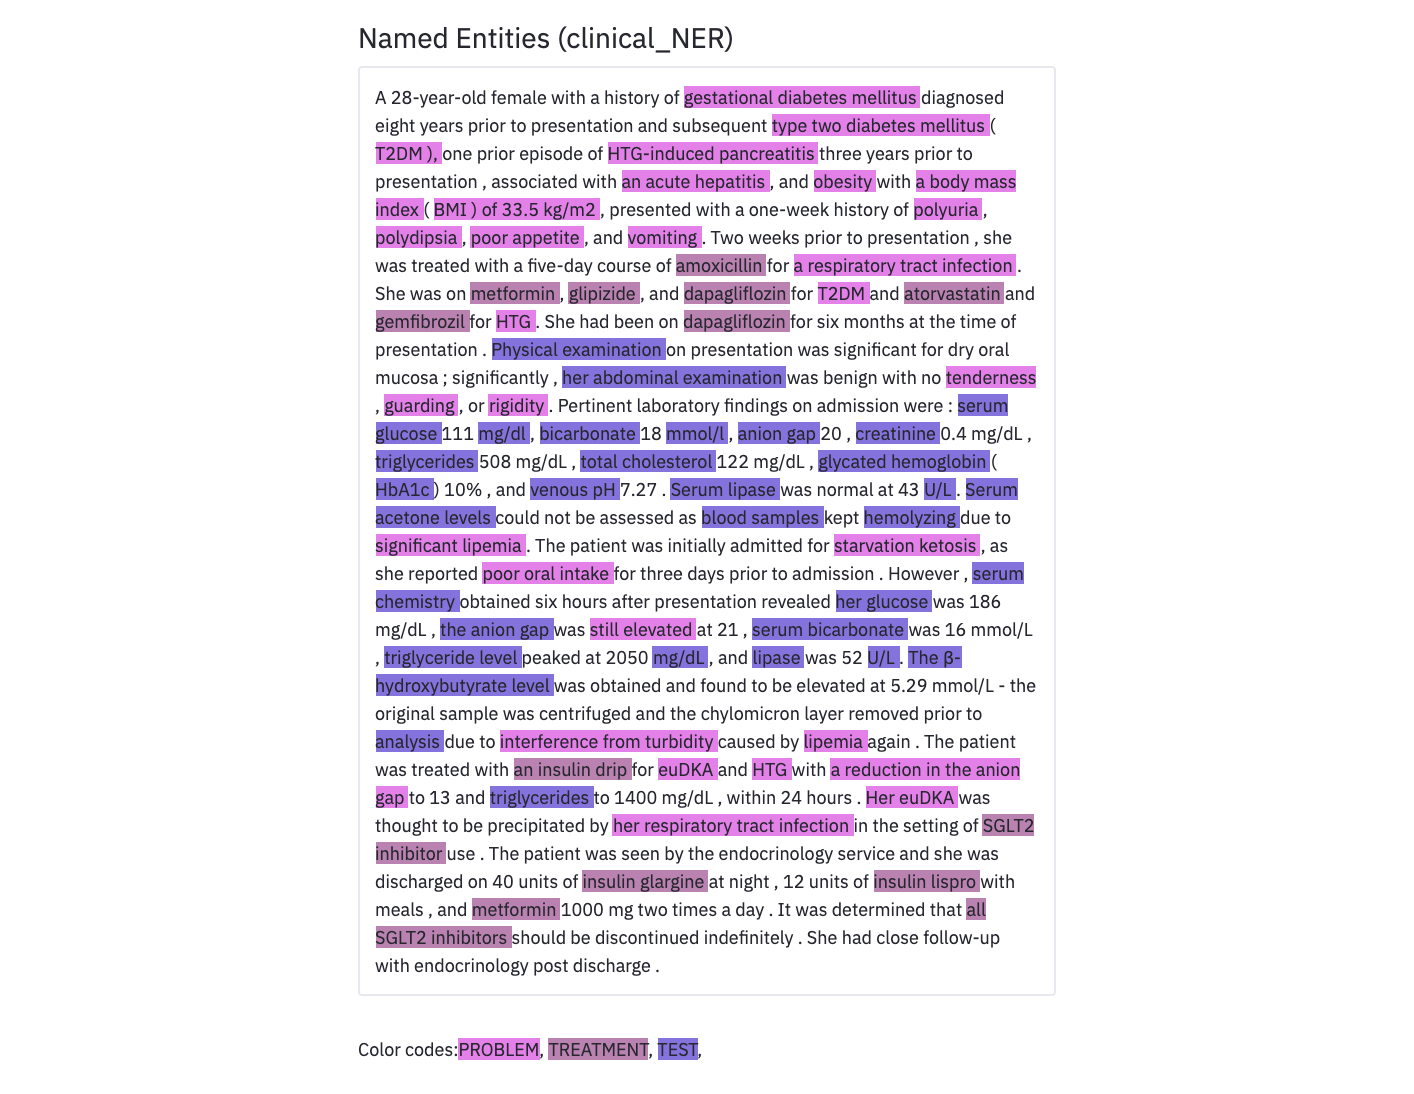

## NER JSL
Let's show an example of `ner_jsl` model that has about 80 clinical entity labels by changing just only the model name.

In [4]:
documentAssembler = DocumentAssembler()\
  .setInputCol("text")\
  .setOutputCol("document")

sentenceDetector = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare","en","clinical/models") \
  .setInputCols(["document"]) \
  .setOutputCol("sentence") 

tokenizer = Tokenizer()\
  .setInputCols(["sentence"])\
  .setOutputCol("token")

word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
  .setInputCols(["sentence", "token"])\
  .setOutputCol("embeddings")

jsl_ner = MedicalNerModel.pretrained("ner_jsl", "en", "clinical/models") \
  .setInputCols(["sentence", "token", "embeddings"]) \
  .setOutputCol("jsl_ner")

jsl_ner_converter = NerConverter() \
  .setInputCols(["sentence", "token", "jsl_ner"]) \
  .setOutputCol("jsl_ner_chunk")

jsl_ner_pipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    jsl_ner,
    jsl_ner_converter])

empty_data = spark.createDataFrame([[""]]).toDF("text")

jsl_ner_model = jsl_ner_pipeline.fit(empty_data)

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 363.9 KB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_jsl download started this may take some time.
Approximate size to download 14.5 MB
[OK!]


In [7]:
print (text)

jsl_light_model = LightPipeline(jsl_ner_model)

jsl_light_result = jsl_light_model.fullAnnotate(text)


chunks = []
entities = []
sentence= []
begin = []
end = []

for n in jsl_light_result[0]['jsl_ner_chunk']:
        
    begin.append(n.begin)
    end.append(n.end)
    chunks.append(n.result)
    entities.append(n.metadata['entity']) 
    sentence.append(n.metadata['sentence'])
    
    
import pandas as pd

df = pd.DataFrame({'chunks':chunks, 'begin': begin, 'end':end, 
                   'sentence_id':sentence, 'entities':entities})

df.head(20)


A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus ( T2DM ), one prior episode of HTG-induced pancreatitis three years prior to presentation , associated with an acute hepatitis , and obesity with a body mass index ( BMI ) of 33.5 kg/m2 , presented with a one-week history of polyuria , polydipsia , poor appetite , and vomiting . Two weeks prior to presentation , she was treated with a five-day course of amoxicillin for a respiratory tract infection . She was on metformin , glipizide , and dapagliflozin for T2DM and atorvastatin and gemfibrozil for HTG . She had been on dapagliflozin for six months at the time of presentation . Physical examination on presentation was significant for dry oral mucosa ; significantly , her abdominal examination was benign with no tenderness , guarding , or rigidity . Pertinent laboratory findings on admission were : serum glucose 111 mg/dl , bicarbonat

,chunks,begin,end,sentence_id,entities
0,28-year-old,3,13,0,Age
1,female,15,20,0,Gender
2,gestational diabetes mellitus,40,68,0,Diabetes
3,eight years prior,80,96,0,RelativeDate
4,subsequent,118,127,0,Modifier
5,type two diabetes mellitus,129,154,0,Diabetes
6,T2DM,158,161,0,Diabetes
7,HTG-induced pancreatitis,187,210,0,Disease_Syndrome_Disorder
8,three years prior,212,228,0,RelativeDate
9,acute,267,271,0,Modifier


In [9]:
from sparknlp_display import NerVisualizer

visualiser = NerVisualizer()

visualiser.display(jsl_light_result[0], label_col='jsl_ner_chunk', document_col='document')

## Posology NER

In [ ]:
# NER model trained on i2b2 (sampled from MIMIC) dataset
posology_ner = MedicalNerModel.pretrained("ner_posology", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner")

posology_ner_greedy = MedicalNerModel.pretrained("ner_posology_greedy", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner_greedy")

ner_converter_greedy = NerConverter()\
    .setInputCols(["sentence","token","ner_greedy"])\
    .setOutputCol("ner_chunk_greedy")

nlpPipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    posology_ner,
    ner_converter,
    posology_ner_greedy,
    ner_converter_greedy])

empty_data = spark.createDataFrame([[""]]).toDF("text")

posology_model = nlpPipeline.fit(empty_data)


ner_posology download started this may take some time.
Approximate size to download 13.8 MB
[OK!]
ner_posology_greedy download started this may take some time.
Approximate size to download 13.9 MB
[OK!]


In [ ]:
posology_ner.getClasses()

['O',
 'B-DOSAGE',
 'B-STRENGTH',
 'I-STRENGTH',
 'B-ROUTE',
 'B-FREQUENCY',
 'I-FREQUENCY',
 'B-DRUG',
 'I-DRUG',
 'B-FORM',
 'I-DOSAGE',
 'B-DURATION',
 'I-DURATION',
 'I-FORM',
 'I-ROUTE']

In [ ]:
posology_result = posology_model.transform(pubMedDF.limit(100))

In [ ]:
posology_result.show(10)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|            sentence|               token|          embeddings|                 ner|           ner_chunk|          ner_greedy|    ner_chunk_greedy|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|The human KCNJ9 (...|[{document, 0, 95...|[{document, 0, 12...|[{token, 0, 2, Th...|[{word_embeddings...|[{named_entity, 0...|                  []|[{named_entity, 0...|[{chunk, 52, 122,...|
|BACKGROUND: At pr...|[{document, 0, 14...|[{document, 0, 19...|[{token, 0, 9, BA...|[{word_embeddings...|[{named_entity, 0...|[{chunk, 167, 180...|[{named_entity, 0...|[{chunk, 167, 180...|
|OBJECTIVE: To inv...|[{document, 0, 15...|[{

In [ ]:
posology_result.printSchema()

root
 |-- text: string (nullable = true)
 |-- document: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- begin: integer (nullable = false)
 |    |    |-- end: integer (nullable = false)
 |    |    |-- result: string (nullable = true)
 |    |    |-- metadata: map (nullable = true)
 |    |    |    |-- key: string
 |    |    |    |-- value: string (valueContainsNull = true)
 |    |    |-- embeddings: array (nullable = true)
 |    |    |    |-- element: float (containsNull = false)
 |-- sentence: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- begin: integer (nullable = false)
 |    |    |-- end: integer (nullable = false)
 |    |    |-- result: string (nullable = true)
 |    |    |-- metadata: map (nullable = true)
 |    |    |    |-- key: string
 |    |    |    |-- value: string (valueContainsNull = true

In [ ]:
from pyspark.sql.functions import monotonically_increasing_id

# This will return a new DF with all the columns + id
posology_result = posology_result.withColumn("id", monotonically_increasing_id())

posology_result.show(3)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---+
|                text|            document|            sentence|               token|          embeddings|                 ner|           ner_chunk|          ner_greedy|    ner_chunk_greedy| id|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---+
|The human KCNJ9 (...|[{document, 0, 95...|[{document, 0, 12...|[{token, 0, 2, Th...|[{word_embeddings...|[{named_entity, 0...|                  []|[{named_entity, 0...|[{chunk, 52, 122,...|  0|
|BACKGROUND: At pr...|[{document, 0, 14...|[{document, 0, 19...|[{token, 0, 9, BA...|[{word_embeddings...|[{named_entity, 0...|[{chunk, 167, 180...|[{named_entity, 0...|[{chunk, 167, 180...|  1|
|OBJECTIVE: To inv...|[{d

In [ ]:
posology_result.select('token.result','ner.result').show(truncate=100)

+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|                                                                                              result|                                                                                              result|
+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|[The, human, KCNJ9, (, Kir, 3.3, ,, GIRK3, ), is, a, member, of, the, G-protein-activated, inward...|[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...|
|[BACKGROUND, :, At, present, ,, it, is, one, of, the, most, important, issues, for, the, treatmen...|[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, 

In [ ]:
posology_result.select('token.result','ner.result').take(2)

[Row(result=['The', 'human', 'KCNJ9', '(', 'Kir', '3.3', ',', 'GIRK3', ')', 'is', 'a', 'member', 'of', 'the', 'G-protein-activated', 'inwardly', 'rectifying', 'potassium', '(', 'GIRK', ')', 'channel', 'family', '.', 'Here', 'we', 'describe', 'the', 'genomicorganization', 'of', 'the', 'KCNJ9', 'locus', 'on', 'chromosome', '1q21-23', 'as', 'a', 'candidate', 'gene', 'forType', 'II', 'diabetes', 'mellitus', 'in', 'the', 'Pima', 'Indian', 'population', '.', 'The', 'gene', 'spansapproximately', '7.6', 'kb', 'and', 'contains', 'one', 'noncoding', 'and', 'two', 'coding', 'exons', 'separated', 'byapproximately', '2.2', 'and', 'approximately', '2.6', 'kb', 'introns', ',', 'respectively', '.', 'We', 'identified14', 'single', 'nucleotide', 'polymorphisms', '(', 'SNPs', '),', 'including', 'one', 'that', 'predicts', 'aVal366Ala', 'substitution', ',', 'and', 'an', '8', 'base-pair', '(', 'bp', ')', 'insertion/deletion', '.', 'Ourexpression', 'studies', 'revealed', 'the', 'presence', 'of', 'the', 'tran

In [ ]:
from pyspark.sql import functions as F

posology_result_df = posology_result.select(F.explode(F.arrays_zip('token.result', 'ner.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("ner_label"))\
        .filter("ner_label!='O'")

posology_result_df.show(20, truncate=100)


+----------------+-----------+
|           token|  ner_label|
+----------------+-----------+
|  anthracyclines|     B-DRUG|
|         taxanes|     B-DRUG|
|     vinorelbine|     B-DRUG|
|     vinorelbine|     B-DRUG|
|  anthracyclines|     B-DRUG|
|         taxanes|     B-DRUG|
|  Vinorelbinewas|     B-DRUG|
|              25| B-STRENGTH|
|          mg/m(2| I-STRENGTH|
|   intravenously|    B-ROUTE|
|              on|B-FREQUENCY|
|            days|I-FREQUENCY|
|tumorprogression|     B-DRUG|
| thatvinorelbine|     B-DRUG|
|  anthracyclines|     B-DRUG|
|         taxanes|     B-DRUG|
|     tetrazolium|     B-DRUG|
|             dye|     I-DRUG|
|             DOX|     B-DRUG|
|    trandolapril|     B-DRUG|
+----------------+-----------+
only showing top 20 rows



In [ ]:
posology_result.select('id',F.explode(F.arrays_zip('ner_chunk.result', 'ner_chunk.begin', 'ner_chunk.end', 'ner_chunk.metadata')).alias("cols")) \
.select('id', F.expr("cols['3']['sentence']").alias("sentence_id"),
        F.expr("cols['0']").alias("chunk"),
        F.expr("cols['1']").alias("begin"),
        F.expr("cols['2']").alias("end"),
        F.expr("cols['3']['entity']").alias("ner_label"))\
        .filter("ner_label!='O'")\
        .show(truncate=False)

+---+-----------+----------------+-----+----+---------+
|id |sentence_id|chunk           |begin|end |ner_label|
+---+-----------+----------------+-----+----+---------+
|1  |0          |anthracyclines  |167  |180 |DRUG     |
|1  |0          |taxanes         |186  |192 |DRUG     |
|1  |1          |vinorelbine     |246  |256 |DRUG     |
|1  |1          |vinorelbine     |386  |396 |DRUG     |
|1  |1          |anthracyclines  |433  |446 |DRUG     |
|1  |1          |taxanes         |452  |458 |DRUG     |
|1  |2          |Vinorelbinewas  |470  |483 |DRUG     |
|1  |2          |25 mg/m(2       |517  |525 |STRENGTH |
|1  |2          |intravenously   |528  |540 |ROUTE    |
|1  |2          |on days         |542  |548 |FREQUENCY|
|1  |3          |tumorprogression|635  |650 |DRUG     |
|1  |11         |thatvinorelbine |1263 |1277|DRUG     |
|1  |11         |anthracyclines  |1380 |1393|DRUG     |
|1  |11         |taxanes         |1399 |1405|DRUG     |
|6  |2          |tetrazolium dye |432  |446 |DRU

In [ ]:
posology_result.select('id',F.explode(F.arrays_zip('ner_chunk_greedy.result', 'ner_chunk_greedy.begin', 'ner_chunk_greedy.end', 'ner_chunk_greedy.metadata')).alias("cols")) \
.select('id', F.expr("cols['3']['sentence']").alias("sentence_id"),
        F.expr("cols['0']").alias("chunk"),
        F.expr("cols['1']").alias("begin"),
        F.expr("cols['2']").alias("end"),
        F.expr("cols['3']['entity']").alias("ner_label"))\
        .filter("ner_label!='O'")\
        .show(truncate=False)

+---+-----------+-----------------------------------------------------------------------+-----+----+---------+
|id |sentence_id|chunk                                                                  |begin|end |ner_label|
+---+-----------+-----------------------------------------------------------------------+-----+----+---------+
|0  |0          |G-protein-activated inwardly rectifying potassium (GIRK) channel family|52   |122 |DRUG     |
|1  |0          |anthracyclines                                                         |167  |180 |DRUG     |
|1  |0          |taxanes                                                                |186  |192 |DRUG     |
|1  |1          |usefulnessof vinorelbine                                               |233  |256 |DRUG     |
|1  |1          |vinorelbine                                                            |386  |396 |DRUG     |
|1  |1          |anthracyclines                                                         |433  |446 |DRUG     |
|

In [ ]:
posology_result.select('ner_chunk').take(2)[1][0][0].result

'anthracyclines'

In [ ]:
posology_result.select('ner_chunk').take(2)[1][0][0].metadata

{'chunk': '0', 'entity': 'DRUG', 'sentence': '0'}

### with LightPipelines

In [ ]:
light_model = LightPipeline(posology_model)

text ='The patient was prescribed 1 capsule of Advil for 5 days . He was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 12 units of insulin lispro with meals , and metformin 1000 mg two times a day . It was determined that all SGLT2 inhibitors should be discontinued indefinitely for 3 months .'

light_result = light_model.annotate(text)

list(zip(light_result['token'], light_result['ner']))

[('The', 'O'),
 ('patient', 'O'),
 ('was', 'O'),
 ('prescribed', 'O'),
 ('1', 'B-DOSAGE'),
 ('capsule', 'B-FORM'),
 ('of', 'O'),
 ('Advil', 'B-DRUG'),
 ('for', 'B-DURATION'),
 ('5', 'I-DURATION'),
 ('days', 'I-DURATION'),
 ('.', 'O'),
 ('He', 'O'),
 ('was', 'O'),
 ('seen', 'O'),
 ('by', 'O'),
 ('the', 'O'),
 ('endocrinology', 'O'),
 ('service', 'O'),
 ('and', 'O'),
 ('she', 'O'),
 ('was', 'O'),
 ('discharged', 'O'),
 ('on', 'O'),
 ('40', 'B-DOSAGE'),
 ('units', 'I-DOSAGE'),
 ('of', 'O'),
 ('insulin', 'B-DRUG'),
 ('glargine', 'I-DRUG'),
 ('at', 'B-FREQUENCY'),
 ('night', 'I-FREQUENCY'),
 (',', 'O'),
 ('12', 'B-DOSAGE'),
 ('units', 'I-DOSAGE'),
 ('of', 'O'),
 ('insulin', 'B-DRUG'),
 ('lispro', 'I-DRUG'),
 ('with', 'B-FREQUENCY'),
 ('meals', 'I-FREQUENCY'),
 (',', 'O'),
 ('and', 'O'),
 ('metformin', 'B-DRUG'),
 ('1000', 'B-STRENGTH'),
 ('mg', 'I-STRENGTH'),
 ('two', 'B-FREQUENCY'),
 ('times', 'I-FREQUENCY'),
 ('a', 'I-FREQUENCY'),
 ('day', 'I-FREQUENCY'),
 ('.', 'O'),
 ('It', 'O'),
 ('was

In [ ]:
list(zip(light_result['token'], light_result['ner_greedy']))

[('The', 'O'),
 ('patient', 'O'),
 ('was', 'O'),
 ('prescribed', 'O'),
 ('1', 'B-DRUG'),
 ('capsule', 'I-DRUG'),
 ('of', 'I-DRUG'),
 ('Advil', 'I-DRUG'),
 ('for', 'B-DURATION'),
 ('5', 'I-DURATION'),
 ('days', 'I-DURATION'),
 ('.', 'O'),
 ('He', 'O'),
 ('was', 'O'),
 ('seen', 'O'),
 ('by', 'O'),
 ('the', 'O'),
 ('endocrinology', 'O'),
 ('service', 'O'),
 ('and', 'O'),
 ('she', 'O'),
 ('was', 'O'),
 ('discharged', 'O'),
 ('on', 'O'),
 ('40', 'B-DRUG'),
 ('units', 'I-DRUG'),
 ('of', 'I-DRUG'),
 ('insulin', 'I-DRUG'),
 ('glargine', 'I-DRUG'),
 ('at', 'B-FREQUENCY'),
 ('night', 'I-FREQUENCY'),
 (',', 'O'),
 ('12', 'B-DRUG'),
 ('units', 'I-DRUG'),
 ('of', 'I-DRUG'),
 ('insulin', 'I-DRUG'),
 ('lispro', 'I-DRUG'),
 ('with', 'B-FREQUENCY'),
 ('meals', 'I-FREQUENCY'),
 (',', 'O'),
 ('and', 'O'),
 ('metformin', 'B-DRUG'),
 ('1000', 'I-DRUG'),
 ('mg', 'I-DRUG'),
 ('two', 'B-FREQUENCY'),
 ('times', 'I-FREQUENCY'),
 ('a', 'I-FREQUENCY'),
 ('day', 'I-FREQUENCY'),
 ('.', 'O'),
 ('It', 'O'),
 ('was', 

In [ ]:
light_result = light_model.fullAnnotate(text)

chunks = []
entities = []
begin =[]
end = []

for n in light_result[0]['ner_chunk']:
        
    begin.append(n.begin)
    end.append(n.end)
    chunks.append(n.result)
    entities.append(n.metadata['entity']) 
    
import pandas as pd

df = pd.DataFrame({'chunks':chunks, 'entities':entities,
                   'begin': begin, 'end': end})

df

,chunks,entities,begin,end
0,1,DOSAGE,27,27
1,capsule,FORM,29,35
2,Advil,DRUG,40,44
3,for 5 days,DURATION,46,55
4,40 units,DOSAGE,126,133
5,insulin glargine,DRUG,138,153
6,at night,FREQUENCY,155,162
7,12 units,DOSAGE,166,173
8,insulin lispro,DRUG,178,191
9,with meals,FREQUENCY,193,202


### NER Visualizer

In [ ]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Public/utils/ner_highlighter.py

In [ ]:
from sparknlp_display import NerVisualizer

visualiser = NerVisualizer()

visualiser.display(light_result[0], label_col='ner_chunk', document_col='document')

# Change color of an entity label

#visualiser.set_label_colors({'PROBLEM':'#008080', 'TEST':'#800080', 'TREATMENT':'#808080'})
#visualiser.display(light_result[0], label_col='ner_chunk')

# Set label filter

# visualiser.display(light_result, label_col='ner_chunk', document_col='document',
                   #labels=['PROBLEM','TEST','TREATMENT])

In [ ]:
# ner_greedy

visualiser = NerVisualizer()

visualiser.display(light_result[0], label_col='ner_chunk_greedy', document_col='document')

## Writing a generic NER function

In [ ]:
def get_base_pipeline (embeddings = 'embeddings_clinical'):

  documentAssembler = DocumentAssembler()\
      .setInputCol("text")\
      .setOutputCol("document")

  # Sentence Detector annotator, processes various sentences per line

  sentenceDetector = SentenceDetector()\
      .setInputCols(["document"])\
      .setOutputCol("sentence")

  # Tokenizer splits words in a relevant format for NLP

  tokenizer = Tokenizer()\
      .setInputCols(["sentence"])\
      .setOutputCol("token")

  # Clinical word embeddings trained on PubMED dataset
  word_embeddings = WordEmbeddingsModel.pretrained(embeddings, "en", "clinical/models")\
      .setInputCols(["sentence", "token"])\
      .setOutputCol("embeddings")

  base_pipeline = Pipeline(stages=[
                    documentAssembler,
                    sentenceDetector,
                    tokenizer,
                    word_embeddings
                  ])

  return base_pipeline



def get_clinical_entities (embeddings, spark_df, nrows = 100, model_name = 'ner_clinical'):

  # NER model trained on i2b2 (sampled from MIMIC) dataset
  loaded_ner_model = MedicalNerModel.pretrained(model_name, "en", "clinical/models") \
      .setInputCols(["sentence", "token", "embeddings"]) \
      .setOutputCol("ner")

  ner_converter = NerConverter() \
      .setInputCols(["sentence", "token", "ner"]) \
      .setOutputCol("ner_chunk")

  base_pipeline = get_base_pipeline (embeddings)

  nlpPipeline = Pipeline(stages=[
      base_pipeline,
      loaded_ner_model,
      ner_converter])

  empty_data = spark.createDataFrame([[""]]).toDF("text")

  model = nlpPipeline.fit(empty_data)

  result = model.transform(spark_df.limit(nrows))

  result = result.withColumn("id", monotonically_increasing_id())

  result_df = result.select('id',F.explode(F.arrays_zip('ner_chunk.result', 'ner_chunk.begin', 'ner_chunk.end', 'ner_chunk.metadata')).alias("cols")) \
  .select('id', F.expr("cols['3']['sentence']").alias("sentence_id"),
          F.expr("cols['0']").alias("chunk"),
          F.expr("cols['1']").alias("begin"),
          F.expr("cols['2']").alias("end"),
          F.expr("cols['3']['entity']").alias("ner_label"))\
          .filter("ner_label!='O'")

  return result_df

In [ ]:
embeddings = 'embeddings_clinical'

model_name = 'ner_clinical'

nrows = 100

ner_df = get_clinical_entities (embeddings, pubMedDF, nrows, model_name)

ner_df.show()

ner_clinical download started this may take some time.
Approximate size to download 13.9 MB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
+---+-----------+--------------------+-----+---+---------+
| id|sentence_id|               chunk|begin|end|ner_label|
+---+-----------+--------------------+-----+---+---------+
|  0|          0|the G-protein-act...|   48|106|TREATMENT|
|  0|          1|the genomicorgani...|  142|164|TREATMENT|
|  0|          1|a candidate gene ...|  210|254|  PROBLEM|
|  0|          2|     byapproximately|  380|394|TREATMENT|
|  0|          3|single nucleotide...|  464|494|TREATMENT|
|  0|          3|aVal366Ala substi...|  532|554|TREATMENT|
|  0|          3|      an 8 base-pair|  561|574|TREATMENT|
|  0|          4|  insertion/deletion|  581|598|  PROBLEM|
|  0|          5|Ourexpression stu...|  601|621|     TEST|
|  0|          5|the transcript in...|  648|685|  PROBLEM|
|  0|          5|fat andskeleta

In [ ]:
embeddings = 'embeddings_clinical'

model_name = 'ner_posology'

nrows = 100

ner_df = get_clinical_entities (embeddings, pubMedDF, nrows, model_name)

ner_df.show()

ner_posology download started this may take some time.
Approximate size to download 13.8 MB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
+---+-----------+----------------+-----+----+---------+
| id|sentence_id|           chunk|begin| end|ner_label|
+---+-----------+----------------+-----+----+---------+
|  1|          0|  anthracyclines|  167| 180|     DRUG|
|  1|          0|         taxanes|  186| 192|     DRUG|
|  1|          1|     vinorelbine|  246| 256|     DRUG|
|  1|          1|     vinorelbine|  386| 396|     DRUG|
|  1|          1|  anthracyclines|  433| 446|     DRUG|
|  1|          1|         taxanes|  452| 458|     DRUG|
|  1|          2|  Vinorelbinewas|  470| 483|     DRUG|
|  1|          2|       25 mg/m(2|  517| 525| STRENGTH|
|  1|          2|   intravenously|  528| 540|    ROUTE|
|  1|          2|         on days|  542| 548|FREQUENCY|
|  1|          3|tumorprogression|  635| 650|     DRUG|
|  1|         

In [ ]:
import pandas as pd

def get_clinical_entities_light (light_model, text):

  light_result = light_model.fullAnnotate(text)

  chunks = []
  entities = []

  for n in light_result[0]['ner_chunk']:
          
      chunks.append(n.result)
      entities.append(n.metadata['entity']) 
      
  df = pd.DataFrame({'chunks':chunks, 'entities':entities})

  return df

In [ ]:
text ='The patient was prescribed 1 capsule of Parol with meals . He was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 12 units of insulin lispro with meals , and metformin 1000 mg two times a day . It was determined that all SGLT2 inhibitors should be discontinued indefinitely fro 3 months .'

light_model = LightPipeline(posology_model)

get_clinical_entities_light (light_model, text)


,chunks,entities
0,1,DOSAGE
1,capsule,FORM
2,Parol,DRUG
3,with meals,FREQUENCY
4,40 units,DOSAGE
5,insulin glargine,DRUG
6,at night,FREQUENCY
7,12 units,DOSAGE
8,insulin lispro,DRUG
9,with meals,FREQUENCY


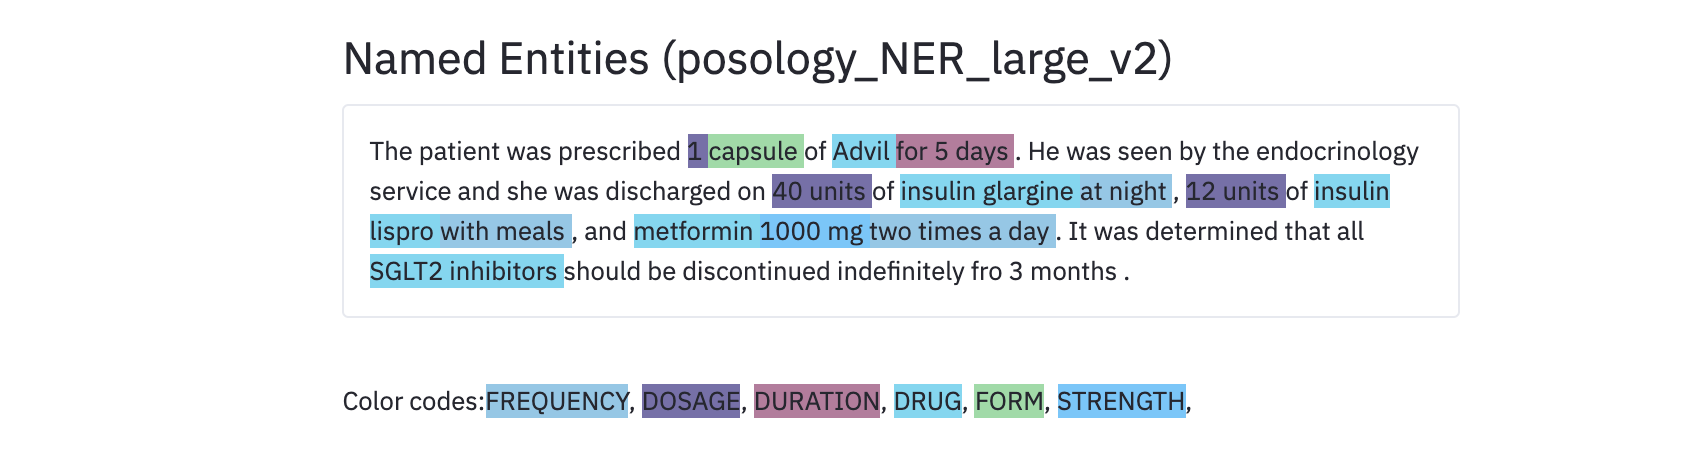

## PHI NER

In [ ]:
embeddings = 'embeddings_clinical'

model_name = 'ner_deid_large'

# deidentify_dl
# ner_deid_large

nrows = 100

ner_df = get_clinical_entities (embeddings, pubMedDF, nrows, model_name)

pd_ner_df = ner_df.toPandas()


ner_deid_large download started this may take some time.
Approximate size to download 14.1 MB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]


In [ ]:
pd_ner_df.sample(20)

,id,sentence_id,chunk,begin,end,ner_label
4,17,0,Yaqui Valley,203,214,LOCATION
15,24,7,dental students weredifferent,1230,1258,PROFESSION
78,95,2,"Beloin, S. Ayora, R",281,299,NAME
64,72,2,Hurricane Katrina,409,425,NAME
12,24,0,Sweden,295,300,LOCATION
81,96,0,British,110,116,LOCATION
11,24,0,Karolinska Institutet,272,292,LOCATION
58,59,1,series of blended,214,230,PROFESSION
65,72,2,Baton Rouge Area Foundation,475,501,LOCATION
57,58,2,Europe,475,480,LOCATION


In [ ]:
pd_ner_df.ner_label.value_counts()

LOCATION      54
DATE          15
NAME           7
PROFESSION     4
AGE            3
Name: ner_label, dtype: int64

## BioNLP (Cancer Genetics) NER

In [ ]:
embeddings = 'embeddings_clinical'

model_name = 'ner_bionlp'

nrows = 100

ner_df = get_clinical_entities (embeddings, pubMedDF, nrows, model_name)

ner_df.show(truncate = False)

ner_bionlp download started this may take some time.
Approximate size to download 13.9 MB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
+---+-----------+----------------------+-----+---+--------------------+
|id |sentence_id|chunk                 |begin|end|ner_label           |
+---+-----------+----------------------+-----+---+--------------------+
|0  |0          |human                 |4    |8  |Organism            |
|0  |0          |Kir 3.3               |17   |23 |Gene_or_gene_product|
|0  |0          |GIRK3                 |26   |30 |Gene_or_gene_product|
|0  |0          |potassium             |92   |100|Simple_chemical     |
|0  |0          |GIRK                  |103  |106|Gene_or_gene_product|
|0  |1          |chromosome 1q21-23    |188  |205|Cellular_component  |
|0  |5          |pancreas              |697  |704|Organ               |
|0  |5          |tissues               |740  |746|Tissue              |
|0  |5  

# NER Chunker
We can extract phrases that fits into a known pattern using the NER tags. NerChunker would be quite handy to extract entity groups with neighboring tokens when there is no pretrained NER model to address certain issues. Lets say we want to extract clinical findings and body parts together as a single chunk even if there are some unwanted tokens between.

In [ ]:
posology_ner = MedicalNerModel.pretrained("ner_posology", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner")

ner_chunker = NerChunker()\
    .setInputCols(["sentence","ner"])\
    .setOutputCol("ner_chunk")\
    .setRegexParsers(["<DRUG>.*<FREQUENCY>"])

nlpPipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    posology_ner,
    ner_chunker])

empty_data = spark.createDataFrame([[""]]).toDF("text")

ner_chunker_model = nlpPipeline.fit(empty_data)

ner_posology download started this may take some time.
Approximate size to download 13.8 MB
[OK!]


In [ ]:
posology_ner.getClasses()

['O',
 'B-DOSAGE',
 'B-STRENGTH',
 'I-STRENGTH',
 'B-ROUTE',
 'B-FREQUENCY',
 'I-FREQUENCY',
 'B-DRUG',
 'I-DRUG',
 'B-FORM',
 'I-DOSAGE',
 'B-DURATION',
 'I-DURATION',
 'I-FORM',
 'I-ROUTE']

In [ ]:
light_model = LightPipeline(ner_chunker_model)

text ='The patient was prescribed 1 capsule of Advil for 5 days . He was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 12 units of insulin lispro with meals , metformin 1000 mg two times a day . It was determined that all SGLT2 inhibitors should be discontinued indefinitely fro 3 months .'

light_result = light_model.annotate(text)

list(zip(light_result['token'], light_result['ner']))

[('The', 'O'),
 ('patient', 'O'),
 ('was', 'O'),
 ('prescribed', 'O'),
 ('1', 'B-DOSAGE'),
 ('capsule', 'B-FORM'),
 ('of', 'O'),
 ('Advil', 'B-DRUG'),
 ('for', 'B-DURATION'),
 ('5', 'I-DURATION'),
 ('days', 'I-DURATION'),
 ('.', 'O'),
 ('He', 'O'),
 ('was', 'O'),
 ('seen', 'O'),
 ('by', 'O'),
 ('the', 'O'),
 ('endocrinology', 'O'),
 ('service', 'O'),
 ('and', 'O'),
 ('she', 'O'),
 ('was', 'O'),
 ('discharged', 'O'),
 ('on', 'O'),
 ('40', 'B-DOSAGE'),
 ('units', 'I-DOSAGE'),
 ('of', 'O'),
 ('insulin', 'B-DRUG'),
 ('glargine', 'I-DRUG'),
 ('at', 'B-FREQUENCY'),
 ('night', 'I-FREQUENCY'),
 (',', 'O'),
 ('12', 'B-DOSAGE'),
 ('units', 'I-DOSAGE'),
 ('of', 'O'),
 ('insulin', 'B-DRUG'),
 ('lispro', 'I-DRUG'),
 ('with', 'B-FREQUENCY'),
 ('meals', 'I-FREQUENCY'),
 (',', 'O'),
 ('metformin', 'B-DRUG'),
 ('1000', 'B-STRENGTH'),
 ('mg', 'I-STRENGTH'),
 ('two', 'B-FREQUENCY'),
 ('times', 'I-FREQUENCY'),
 ('a', 'I-FREQUENCY'),
 ('day', 'I-FREQUENCY'),
 ('.', 'O'),
 ('It', 'O'),
 ('was', 'O'),
 ('det

In [ ]:
light_result["ner_chunk"]

['insulin glargine at night , 12 units of insulin lispro with meals , metformin 1000 mg two times a day']

# Chunk Filterer
ChunkFilterer will allow you to filter out named entities by some conditions or predefined look-up lists, so that you can feed these entities to other annotators like Assertion Status or Entity Resolvers. It can be used with two criteria: isin and regex.

In [ ]:
posology_ner = MedicalNerModel.pretrained("ner_posology", "en", "clinical/models") \
      .setInputCols(["sentence", "token", "embeddings"]) \
      .setOutputCol("ner")

ner_converter = NerConverter()\
      .setInputCols(["sentence","token","ner"])\
      .setOutputCol("ner_chunk")
      
chunk_filterer = ChunkFilterer()\
      .setInputCols("sentence","ner_chunk")\
      .setOutputCol("chunk_filtered")\
      .setCriteria("isin")\
      .setWhiteList(['Advil','metformin', 'insulin lispro'])

nlpPipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    posology_ner,
    ner_converter,
    chunk_filterer])

empty_data = spark.createDataFrame([[""]]).toDF("text")

chunk_filter_model = nlpPipeline.fit(empty_data)

ner_posology download started this may take some time.
Approximate size to download 13.8 MB
[OK!]


In [ ]:
light_model = LightPipeline(chunk_filter_model)

text ='The patient was prescribed 1 capsule of Advil for 5 days . He was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 12 units of insulin lispro with meals , metformin 1000 mg two times a day . It was determined that all SGLT2 inhibitors should be discontinued indefinitely fro 3 months .'

light_result = light_model.annotate(text)

light_result.keys()

dict_keys(['document', 'ner_chunk', 'chunk_filtered', 'token', 'ner', 'embeddings', 'sentence'])

In [ ]:
light_result['ner_chunk'] 

['1',
 'capsule',
 'Advil',
 'for 5 days',
 '40 units',
 'insulin glargine',
 'at night',
 '12 units',
 'insulin lispro',
 'with meals',
 'metformin',
 '1000 mg',
 'two times a day',
 'SGLT2 inhibitors']

In [ ]:
light_result['chunk_filtered']

['Advil', 'insulin lispro', 'metformin']

In [ ]:
ner_model = MedicalNerModel.pretrained("ner_clinical", "en", "clinical/models")\
      .setInputCols("sentence","token","embeddings")\
      .setOutputCol("ner")

ner_converter = NerConverter()\
      .setInputCols(["sentence","token","ner"])\
      .setOutputCol("ner_chunk")
      
chunk_filterer = ChunkFilterer()\
      .setInputCols("sentence","ner_chunk")\
      .setOutputCol("chunk_filtered")\
      .setCriteria("isin")\
      .setWhiteList(['severe fever','sore throat'])

nlpPipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    ner_model,
    ner_converter,
    chunk_filterer])

empty_data = spark.createDataFrame([[""]]).toDF("text")

chunk_filter_model = nlpPipeline.fit(empty_data)

ner_clinical download started this may take some time.
Approximate size to download 13.9 MB
[OK!]


In [ ]:
text = 'Patient with severe fever, severe cough, sore throat, stomach pain, and a headache.'

filter_df = spark.createDataFrame([[text]]).toDF("text")

chunk_filter_result = chunk_filter_model.transform(filter_df)

In [ ]:
chunk_filter_result.select('ner_chunk.result','chunk_filtered.result').show(truncate=False)

+-------------------------------------------------------------------+---------------------------+
|result                                                             |result                     |
+-------------------------------------------------------------------+---------------------------+
|[severe fever, severe cough, sore throat, stomach pain, a headache]|[severe fever, sore throat]|
+-------------------------------------------------------------------+---------------------------+



# Training a Clinical NER (NCBI Disease Dataset)

In [ ]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/NER_NCBIconlltrain.txt
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/NER_NCBIconlltest.txt

In [ ]:
from sparknlp.training import CoNLL

conll_data = CoNLL().readDataset(spark, 'NER_NCBIconlltrain.txt')

conll_data.show(3)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|            sentence|               token|                 pos|               label|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|Identification of...|[{document, 0, 89...|[{document, 0, 89...|[{token, 0, 13, I...|[{pos, 0, 13, NN,...|[{named_entity, 0...|
|The adenomatous p...|[{document, 0, 21...|[{document, 0, 21...|[{token, 0, 2, Th...|[{pos, 0, 2, NN, ...|[{named_entity, 0...|
|Complex formation...|[{document, 0, 63...|[{document, 0, 63...|[{token, 0, 6, Co...|[{pos, 0, 6, NN, ...|[{named_entity, 0...|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 3 rows



In [ ]:
conll_data.count()

3266

In [ ]:
from pyspark.sql import functions as F

conll_data.select(F.explode(F.arrays_zip('token.result','label.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("ground_truth")).groupBy('ground_truth').count().orderBy('count', ascending=False).show(100,truncate=False)


+------------+-----+
|ground_truth|count|
+------------+-----+
|O           |75093|
|I-Disease   |3547 |
|B-Disease   |3093 |
+------------+-----+



In [ ]:
conll_data.select("label.result").distinct().count()

1537

In [ ]:
import pyspark.sql.functions as F

#conll_data.select(F.countDistinct("label.result")).show()
#conll_data.groupBy("label.result").count().show(truncate=False)

conll_data = conll_data.withColumn('unique', F.array_distinct("label.result"))\
.withColumn('c', F.size('unique'))\
.filter(F.col('c')>1)

conll_data.select(F.explode(F.arrays_zip('token.result','label.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("ground_truth")).groupBy('ground_truth').count().orderBy('count', ascending=False).show(100,truncate=False)



+------------+-----+
|ground_truth|count|
+------------+-----+
|O           |39427|
|I-Disease   |3547 |
|B-Disease   |3093 |
+------------+-----+



In [ ]:
# Clinical word embeddings trained on PubMED dataset
clinical_embeddings = WordEmbeddingsModel.pretrained('embeddings_clinical', "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")


embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]


In [ ]:
test_data = CoNLL().readDataset(spark, 'NER_NCBIconlltest.txt')

test_data = clinical_embeddings.transform(test_data)

#test_data.write.parquet('NER_NCBIconlltest.parquet')

### NERDL Graph
TensorFlow graph file (`.pb` extension) should be produced for NER training.

In [ ]:
from sparknlp_jsl.training import tf_graph
%tensorflow_version 1.x
tf_graph.print_model_params("ner_dl")

tf_graph.build("ner_dl", build_params={"embeddings_dim": 200, "nchars": 83, "ntags": 12, "is_medical": 1}, model_location="./medical_ner_graphs", model_filename="auto")

In [ ]:
# for open source users
'''
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jupyter/training/english/dl-ner/nerdl-graph/create_graph.py
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jupyter/training/english/dl-ner/nerdl-graph/dataset_encoder.py
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jupyter/training/english/dl-ner/nerdl-graph/ner_model.py
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jupyter/training/english/dl-ner/nerdl-graph/ner_model_saver.py
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jupyter/training/english/dl-ner/nerdl-graph/sentence_grouper.py

!pip -q install tensorflow==1.15.0

import create_graph

ntags = 3 # number of labels
embeddings_dim = 200
nchars =83

create_graph.create_graph(ntags, embeddings_dim, nchars)
'''

In [ ]:
nerTagger = MedicalNerApproach()\
      .setInputCols(["sentence", "token", "embeddings"])\
      .setLabelColumn("label")\
      .setOutputCol("ner")\
      .setMaxEpochs(2)\
      .setBatchSize(64)\
      .setRandomSeed(0)\
      .setVerbose(1)\
      .setValidationSplit(0.2)\
      .setEvaluationLogExtended(True) \
      .setEnableOutputLogs(True)\
      .setIncludeConfidence(True)\
      .setOutputLogsPath('ner_logs')\
      .setGraphFolder('medical_ner_graphs')\
      .setEnableMemoryOptimizer(True) #>> if you have a limited memory and a large conll file, you can set this True to train batch by batch 
      #.setTestDataset("NER_NCBIconlltest.parquet")\
ner_pipeline = Pipeline(stages=[
          clinical_embeddings,
          nerTagger
 ])

In [ ]:
%%time
# 2 epochs around 2 min
ner_model = ner_pipeline.fit(conll_data)

# if you get an error for incompatible TF graph, use 4.1 NerDL-Graph.ipynb notebook in public folder to create a graph
# licensed users can also use 17.Graph_builder_for_DL_models.ipynb to create tf graphs easily.

CPU times: user 607 ms, sys: 97.5 ms, total: 704 ms
Wall time: 1min 58s


In [ ]:
!cd ner_logs && ls -lt

total 4
-rw-r--r-- 1 root root 1224 Jun 24 08:50 MedicalNerApproach_1e3c3bc34978.log


In [ ]:
! cat ner_logs/MedicalNerApproach_1e3c3bc34978.log

Name of the selected graph: /content/medical_ner_graphs/blstm_12_200_128_83.pb
Training started - total epochs: 2 - lr: 0.001 - batch size: 64 - labels: 3 - chars: 82 - training examples: 1381


Epoch 1/2 started, lr: 0.001, dataset size: 1381


Epoch 1/2 - 50.15s - loss: 378.17838 - batches: 22
Quality on validation dataset (20.0%), validation examples = 276
time to finish evaluation: 7.48s
label	 tp	 fp	 fn	 prec	 rec	 f1
I-Disease	 52	 8	 642	 0.8666667	 0.074927956	 0.13793103
B-Disease	 80	 113	 517	 0.41450778	 0.13400336	 0.20253165
tp: 132 fp: 121 fn: 1159 labels: 2
Macro-average	 prec: 0.6405872, rec: 0.104465656, f1: 0.17963655
Micro-average	 prec: 0.5217391, rec: 0.10224632, f1: 0.17098445


Epoch 2/2 started, lr: 9.950249E-4, dataset size: 1381


Epoch 2/2 - 45.08s - loss: 186.8442 - batches: 22
Quality on validation dataset (20.0%), validation examples = 276
time to finish evaluation: 6.77s
label	 tp	 fp	 fn	 prec	 rec	 f1
I-Disease	 444	 333	 250	 0.5714286	 0.63976943	 0

### Evaluate your model

In [ ]:
pred_df = ner_model.stages[1].transform(test_data)

In [ ]:
pred_df.columns

['text', 'document', 'sentence', 'token', 'pos', 'label', 'embeddings', 'ner']

In [ ]:
from sparknlp_jsl.eval import NerDLMetrics
import pyspark.sql.functions as F

evaler = NerDLMetrics(mode="full_chunk", dropO=True)

eval_result = evaler.computeMetricsFromDF(pred_df.select("label","ner"), prediction_col="ner", label_col="label").cache()

eval_result.withColumn("precision", F.round(eval_result["precision"],4))\
    .withColumn("recall", F.round(eval_result["recall"],4))\
    .withColumn("f1", F.round(eval_result["f1"],4)).show(100)

print(eval_result.selectExpr("avg(f1) as macro").show())
print (eval_result.selectExpr("sum(f1*total) as sumprod","sum(total) as sumtotal").selectExpr("sumprod/sumtotal as micro").show())

+-------+-----+-----+-----+-----+---------+------+-----+
| entity|   tp|   fp|   fn|total|precision|recall|   f1|
+-------+-----+-----+-----+-----+---------+------+-----+
|Disease|360.0|379.0|344.0|704.0|   0.4871|0.5114|0.499|
+-------+-----+-----+-----+-----+---------+------+-----+

+-----------------+
|            macro|
+-----------------+
|0.498960498960499|
+-----------------+

None
+-----------------+
|            micro|
+-----------------+
|0.498960498960499|
+-----------------+

None


In [ ]:
evaler = NerDLMetrics(mode="partial_chunk_per_token", dropO=True)

eval_result = evaler.computeMetricsFromDF(pred_df.select("label","ner"), prediction_col="ner", label_col="label").cache()

eval_result.withColumn("precision", F.round(eval_result["precision"],4))\
    .withColumn("recall", F.round(eval_result["recall"],4))\
    .withColumn("f1", F.round(eval_result["f1"],4)).show(100)

print(eval_result.selectExpr("avg(f1) as macro").show())
print (eval_result.selectExpr("sum(f1*total) as sumprod","sum(total) as sumtotal").selectExpr("sumprod/sumtotal as micro").show())

+-------+------+-----+-----+------+---------+------+------+
| entity|    tp|   fp|   fn| total|precision|recall|    f1|
+-------+------+-----+-----+------+---------+------+------+
|Disease|1050.0|297.0|447.0|1497.0|   0.7795|0.7014|0.7384|
+-------+------+-----+-----+------+---------+------+------+

+------------------+
|             macro|
+------------------+
|0.7383966244725738|
+------------------+

None
+------------------+
|             micro|
+------------------+
|0.7383966244725738|
+------------------+

None


In [ ]:
ner_model.stages[1].write().overwrite().save('models/custom_NER_2epoch')

In [ ]:
document = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentence = SentenceDetector()\
    .setInputCols(['document'])\
    .setOutputCol('sentence')

token = Tokenizer()\
    .setInputCols(['sentence'])\
    .setOutputCol('token')

loaded_ner_model = MedicalNerModel.load("models/custom_NER_2epoch")\
    .setInputCols(["sentence", "token", "embeddings"])\
    .setOutputCol("ner")

converter = NerConverter()\
    .setInputCols(["document", "token", "ner"])\
    .setOutputCol("ner_span")

ner_prediction_pipeline = Pipeline(
    stages = [
        document,
        sentence,
        token,
        clinical_embeddings,
        loaded_ner_model,
        converter])

empty_data = spark.createDataFrame([['']]).toDF("text")

prediction_model = ner_prediction_pipeline.fit(empty_data)

from sparknlp.base import LightPipeline

light_model = LightPipeline(prediction_model)

In [ ]:
text = "She has a metastatic breast cancer to her lungs"

def get_preds(text, light_model):

    result = light_model.fullAnnotate(text)[0]

    return [(i.result, i.metadata['entity']) for i in result['ner_span']]

get_preds(text, light_model)

[('metastatic', 'Disease'), ('breast cancer', 'Disease')]